<a href="https://colab.research.google.com/github/Abril1030/AbrilPublicRepo/blob/main/Bloque_ETL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



> Instalación en terminal de librería para SVG



In [ ]:
pip install cairosvg



> Importación de librerías usadas para el proyecto



In [2]:
import codecs
import cairosvg
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.animation as animation
#from numba import njit
from io import BytesIO
from PIL import Image



> Conversión de bits de PNG a Numpy



In [3]:
def png_bytes_to_numpy(png):
    """Convert png bytes to numpy array

    Example:  

    >>> fig = go.Figure(go.Scatter(x=[1], y=[1]))
    >>> plt.imshow(png_bytes_to_numpy(fig.to_image('png')))
    """
    return np.array(Image.open(BytesIO(png)))



> Función que se encarga de formatear la información para lo que se requiere



In [4]:
def get_form_data(Diccionary,sheet):
    alineacion = Diccionary.get('ALIN2')
    alingREad = alineacion.iloc[8:596,:199] #Para llamar las lecturas de los sensores.
    EncabezadoAling = alingREad.iloc[0]
    alingREad.columns = EncabezadoAling
    alingREad=alingREad.drop(labels=[8], axis=0)
    return alingREad



> Definición de función inicial



In [5]:
def init_fnc(filename):
    global content_svg
    content_svg=[]
    for _file in filename:
        with codecs.open(_file, encoding='utf-8', errors='ignore') as f:
            svg_as_text=f.read()
            svg_as_text=svg_as_text.replace('"st0"', '"stk"')
            for i in range(99):
                svg_as_text=svg_as_text.replace('"stk"','"st{}"'.format(i),1)
            content_svg.append(svg_as_text)



> Función para convertir datos SVG a Imagen



In [6]:
def svg2img(foot,data_sensors):
    global content_svg
    
    content=content_svg[foot]
    style_m1=".st{0}{1}\n\t"
    style_m2="{{fill:#{0}}}"
    style_temp=""
    
    for i in range(len(data_sensors)):
        k=''
        k=['0' for i in range(6-len(data_sensors[i]))]
        k="".join(k)
        if len(data_sensors[i])>0:
            style_temp+=style_m1.format(i,style_m2.format(k+str(data_sensors[i])+';'))
        else:
            style_temp+=style_m1.format(i,style_m2.format('000000;'))

    style_c=content.find('.st0')
    sub_str=content[style_c:style_c+19]
    svg_loc=content.replace(sub_str, style_temp)

    png_data = cairosvg.svg2png(bytestring=svg_loc.encode())
    img_out=png_bytes_to_numpy(png_data)
    return img_out



> Cargue del Excel y guardado en Diccionario de datos. Precarga de archivos SVG



In [8]:
Archivo = 'PRESION_NO_ALIN_V2.xlsx' #Carga el excel
Diccionario = pd.read_excel(Archivo, sheet_name=None, index_col=False)

#Sujetos = Diccionario.get('SUJETOS')

init_fnc(["foot L.svg","foot R.svg"])#Precarga los svg del directorio para L y R



> Visualización 2D



<ipython-input-9-c5d2dbe2fb56>:9: FutureWarning: The default value of numeric_only in DataFrame.max is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  max_dts=data_readed.max(skipna=True)


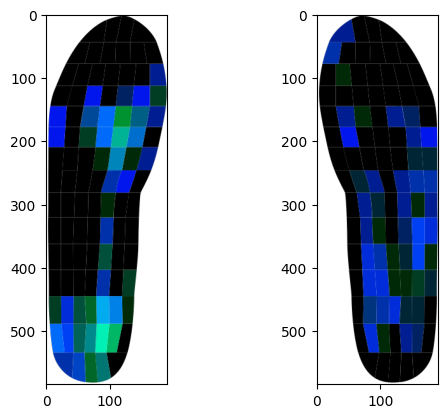

In [9]:
#definiciones para animación 

fig, (ax1, ax2) = plt.subplots(1,2) #1 fila, 2 columnas
x=0
ims = []

data_readed= get_form_data(Diccionario,'ALIN2')
data_readed_list=data_readed.to_numpy().tolist()
max_dts=data_readed.max(skipna=True)
max_dt=max(max_dts)


for i in range(len(data_readed_list)-10):
    heat_map = data_readed.iloc[i].to_numpy(copy=True)
    heat_map=list(map(float, heat_map))
    heat_map=[(y/max_dt)*0x00FFFF for y in heat_map]
    heat_map_v=list(map(int, heat_map))

    data_sensor_hex=[hex(data)for data in heat_map_v]
    data_sensor_str=[data_sh.replace('0x','') for data_sh in data_sensor_hex]
    Img_L=svg2img(0,data_sensor_str[0:100])#0 para izquierda
    Img_R=svg2img(1,data_sensor_str[100:199])#1 para derecha

    im_l= ax1.imshow(Img_L, animated=True)
    im_r= ax2.imshow(Img_R, animated=True)
    if i == 0:
        ax1.imshow(Img_L)  # Imagen inicial
        ax2.imshow(Img_R)
    ims.append([im_l,im_r])

ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)
plt.show() #Funciona